## **Evaluator-Optimizer Workflow**


In [57]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [58]:
# Pydantic schema
class llm_schema(BaseModel):
    funny_flag: Literal["funny", "not_funny"] = Field(
        description="Whether the joke is funny or not")

In [59]:
llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_schema = llm.with_structured_output(llm_schema)

In [60]:
# graph schema
class graph_schema(TypedDict):

    topic: str
    joke: str
    funny_flag: str

In [61]:
# Nodes

def generate_node(state: graph_schema) -> graph_schema:
    topic = state['topic']

    response = llm.invoke(
        "Create only one joke about the following topic: " + topic)

    state['joke'] = response.content
    return state


def is_funny(state: graph_schema) -> graph_schema:
    joke = state['joke']

    prompt = ChatPromptTemplate.from_messages([
        ("system",
         """You are a comedy critic. Determine if the joke is funny or not_funny: {joke}.
         Funny joke criteria:
         1. It should be unexpected and surprising.
         2. It should be relatable to a wide audience.
         3. It should have a clever twist or wordplay.
         4. It should evoke laughter or amusement.
         5. It should be concise and well-timed.

         ONLY reply with "funny" or "not_funny". """),

        ("user", f"{joke}")
    ])

    chain = prompt | llm_with_schema
    response = chain.invoke({"joke": joke})

    state['funny_flag'] = response.funny_flag
    return state


def evaluate_node(state: graph_schema) -> graph_schema:
    joke = state['joke']

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a comedy critic. Your job is to evaluate the following joke to make it more funnier."),
        ("user",
         f"Evaluate and enhance the following joke: {joke}\n")
    ])

    chain = prompt | llm
    response = chain.invoke({"joke": joke})

    # update the joke in the state with the evaluated joke
    state['joke'] = response.content
    return state

In [62]:
# conditional edge
def router(state: graph_schema):
    if state['funny_flag'] == "funny":
        return "YES"
    else:
        return "NO"

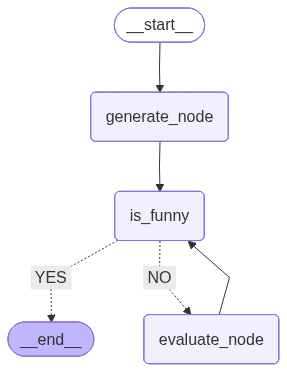

In [63]:
graph = StateGraph(graph_schema)

graph.add_node("generate_node", generate_node)
graph.add_node("is_funny", is_funny)
graph.add_node("evaluate_node", evaluate_node)

graph.add_edge(START, "generate_node")
graph.add_edge("generate_node", "is_funny")

graph.add_conditional_edges("is_funny", router, {
    "YES": END,
    "NO": "evaluate_node"
})

# only loop back
graph.add_edge("evaluate_node", "is_funny")

evaluator_graph = graph.compile()
evaluator_graph

In [64]:
for chunk in evaluator_graph.stream(
    {
        "topic": "cars",
        "funny_flag": "",
        "joke": ""
    },
    stream_mode="updates"
):
    print(chunk)

{'generate_node': {'topic': 'cars', 'joke': 'Why did the car go to the doctor? \n\nBecause it was feeling a little "car-sick"!', 'funny_flag': ''}}
{'is_funny': {'topic': 'cars', 'joke': 'Why did the car go to the doctor? \n\nBecause it was feeling a little "car-sick"!', 'funny_flag': 'funny'}}


In [65]:
print(chunk["is_funny"]["joke"])

Why did the car go to the doctor? 

Because it was feeling a little "car-sick"!
